In [1]:
!pip install statsmodels

     |████████████████████████████████| 9.5 MB 5.3 MB/s eta 0:00:01     |█████▌                          | 1.6 MB 5.3 MB/s eta 0:00:02
     |████████████████████████████████| 231 kB 32.8 MB/s eta 0:00:01
You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.


In [2]:
import os
import pandas as pd
import zipfile
import numpy as np
import tensorflow as tf
import h5py
import random
from scipy import ndimage
import shutil
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import sklearn
import tempfile
import datetime
from statsmodels.stats.proportion import proportion_confint
from functions.auc_delong_xu import auc_ci_Delong

from tensorflow import keras
from tensorflow.keras import layers
from keras.utils import to_categorical
from keras.layers.merge import concatenate
from tensorflow.keras import regularizers

from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import Session
import gc

from keras import backend as K

In [4]:
tf.__version__

'2.4.0'

### Import data from HD5File

Checking the data

In [8]:
PATH_3D_H5 = 'Images/preprocessed_data_128_112_40_all.hdf5'
with h5py.File(PATH_3D_H5, 'r') as h5:
    print('H5-file: ', list(h5.keys()))

    X = h5["X"][:]
    Y_pat = h5["Y_pat"][:]
    pat = h5["pat"][:]

print(X.shape, X.min(), X.max(), X.mean(), X.std(), Y_pat.shape, pat.shape)

H5-file:  ['X', 'Y_pat', 'pat']
(508, 128, 112, 40, 1) -1.5907471988589987 26.031565772467758 2.1324024910545048e-18 0.9999999999999966 (508,) (508,)


### Data Augmentation

Zoom images

In [82]:
# zoom
def random_zoom3d(X_im, min_zoom, max_zoom):
    z = np.random.sample() *(max_zoom-min_zoom) + min_zoom
    zoom_matrix = np.array([[z, 0, 0, 0],
                            [0, z, 0, 0],
                            [0, 0, z, 0],
                            [0, 0, 0, 1]])
    return ndimage.affine_transform(X_im, zoom_matrix, mode = "nearest", order = 1)

In [43]:
X1 = X[0]

(128, 112, 40, 1)

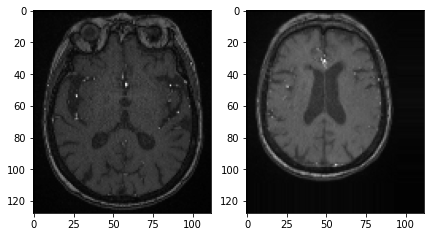

In [76]:
X1 = X[5]
X_aug_zoom = random_zoom3d(X1, 0.8,1.3)
fig, axis= plt.subplots(1,2, figsize = (7,10))

axis[0].imshow(np.squeeze(X1[:, :, 29]), cmap="gray")
axis[1].imshow(np.squeeze(X_aug_zoom[:,:,29]), cmap="gray")
p = "Zoomed_image"

Rotate images

In [81]:
# rotate
def random_rotate3d(X_im, min_angle_xy, max_angle_xy, min_angle_xz, max_angle_xz, min_angle_yz, max_angle_yz):
    angle_xy = np.random.uniform(min_angle_xy, max_angle_xy)
    angle_xz = np.random.uniform(min_angle_xz, max_angle_xz)
    angle_yz = np.random.uniform(min_angle_yz, max_angle_yz)
    rotation_axis = np.random.choice([0,1,2])
    if(rotation_axis == 0):
        X_im = ndimage.rotate(X_im, angle = angle_xy, axes = (0,1), mode = "nearest", reshape = False, order = 3)
    if(rotation_axis == 1):
        X_im = ndimage.rotate(X_im, angle = angle_xz, axes = (0,2), mode = "nearest", reshape = False, order = 3)
    if(rotation_axis == 2):
        X_im = ndimage.rotate(X_im, angle = angle_yz, axes = (1,2), mode = "nearest", reshape = False, order = 3)
    return X_im

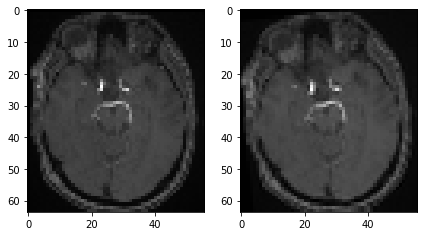

In [294]:
x = X_train[0]
X_aug = random_rotate3d(x, -20, 20, -10, 10, -5, 5)
fig, axis= plt.subplots(1,2, figsize = (7,10))

axis[0].imshow(np.squeeze(x[:, :, 10]), cmap="gray")
axis[1].imshow(np.squeeze(X_aug[:,:,10]), cmap="gray")

Shifting images

In [80]:
# shifting
def random_shift3d(X_im, min_shift_x, max_shift_x, min_shift_y, max_shift_y, min_shift_z, max_shift_z):
    x_shift = np.random.uniform(min_shift_x, max_shift_x)
    y_shift = np.random.uniform(min_shift_y, max_shift_y)
    z_shift = np.random.uniform(min_shift_z, max_shift_z)
    return ndimage.shift(X_im, [x_shift, y_shift, z_shift, 0], mode = "nearest", order = 0)

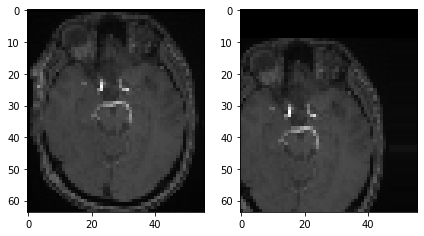

In [286]:
x = X_train[0]
X_aug = random_shift3d(x, -10, 10, -10, 10, 0, 0)
fig, axis= plt.subplots(1,2, figsize = (7,10))

axis[0].imshow(np.squeeze(x[:, :, 10]), cmap="gray")
axis[1].imshow(np.squeeze(X_aug[:,:,10]), cmap="gray")

Flipping images

In [79]:
def random_flip3d(X_im):
    axis = np.random.choice([0,1])
    if(axis == 0): # vertical flip
        X_im = X_im[:,::-1,:,:]
        # X_im = X_im[::-1,:,:,:] #horizontal
        # X_im = np.asarray(X_im).swapaxes(0, 1)#left, right flip
    return X_im

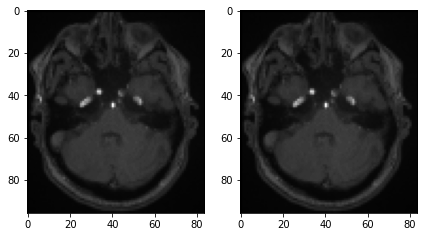

In [147]:
x = X_train[0]
X_aug = random_flip3d(x)
fig, axis= plt.subplots(1,2, figsize = (7,10))

axis[0].imshow(np.squeeze(x[:, :, 10]), cmap="gray")
axis[1].imshow(np.squeeze(X_aug[:,:,10]), cmap="gray")

Gauss filter

In [83]:
# Gauss filter (Glättung, Mittelwertberechnung per Pixel basierend auf umgebenden Pixeln ausgewählt mit Gaussfkt.)
def random_gaussianfilter3d(X_im, sigma_max):
    sigma = np.random.uniform(0, sigma_max)
    return ndimage.gaussian_filter(X_im, sigma, mode = "nearest")

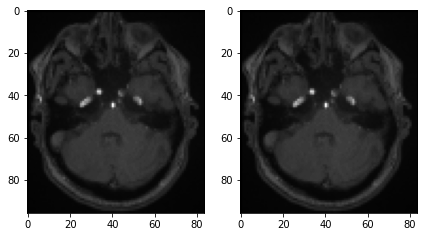

In [150]:
x = X_train[0]
X_aug = random_gaussianfilter3d(x, 0.2)
fig, axis= plt.subplots(1,2, figsize = (7,10))

axis[0].imshow(np.squeeze(x[:, :, 10]), cmap="gray")
axis[1].imshow(np.squeeze(X_aug[:,:,10]), cmap="gray")

In [10]:
@tf.function
def augment_3d_one(volume):
    """Rotate the volume by a few degrees"""

    def augment(volume):
        rand = np.random.randint(0,6)
        
        if rand == 0:
            volume = random_zoom3d(volume, 0.8, 1.3)
        if rand == 1:
            volume = random_rotate3d(volume, -20, 20, -5, 5, -5, 5)
        if rand == 2:
            volume = random_shift3d(volume, -20, 20, -20, 20, 0, 0) #do not shift in z direction
        if rand == 3:
            volume = random_flip3d(volume)
        if rand == 4:
            volume = random_gaussianfilter3d(volume, 0.2)
        if rand == 5:
            volume = volume

        return volume
    
    volume_shape = volume.shape
    augmented_volume = tf.numpy_function(augment, [volume], np.float64)
    augmented_volume = tf.reshape(augmented_volume, volume_shape)
    return augmented_volume

In [90]:
@tf.function
def augment_3d_two(volume):
    """Rotate the volume by a few degrees"""

    def augment(volume):
        rand = np.random.randint(0,5, size = 2)
            
        if 0 in rand:
            volume = random_zoom3d(volume, 0.8,1.3) 
        if 1 in rand:
            volume = random_rotate3d(volume, -20, 20, -5, -5, -5, -5)
        if 2 in rand:
            volume = random_shift3d(volume, -20, 20, -20, 20, 0, 0) #do not shift in z direction
        if 3 in rand:
            volume = random_flip3d(volume)
        if 4 in rand:
            volume = random_gaussianfilter3d(volume, 0.2)
            
        return volume
    
    volume_shape = volume.shape
    augmented_volume = tf.numpy_function(augment, [volume], np.float64)
    augmented_volume = tf.reshape(augmented_volume, volume_shape)
    return augmented_volume

In [91]:
def train_preprocessing(volume, label):
    volume = augment_3d_two(volume)
    return volume, label

In [92]:
def get_dataset(X_train, Y_train, X_valid, Y_valid):
    Y_train = to_categorical(Y_train)
    Y_valid = to_categorical(Y_valid)
    
    bool_train_labels = Y_train[:,1] != 0
    pos_features = X_train[bool_train_labels]
    neg_features = X_train[~bool_train_labels]
    pos_labels = Y_train[bool_train_labels]
    neg_labels = Y_train[~bool_train_labels]
    
    def make_ds(features, labels):
        ds = tf.data.Dataset.from_tensor_slices((features, labels))#.cache()
        ds = ds.shuffle(len(pos_features)*2).repeat()
        return ds

    pos_ds = make_ds(pos_features, pos_labels)
    neg_ds = make_ds(neg_features, neg_labels)
    
    resampled_ds = tf.data.experimental.sample_from_datasets([pos_ds, neg_ds], weights=[0.5, 0.5])
    validation_loader = tf.data.Dataset.from_tensor_slices((X_valid, Y_valid))

    batch_size = 2
    # Augment the on the fly during training.
    train_dataset = (
        resampled_ds.shuffle(buffer_size = (len(pos_features)*2), reshuffle_each_iteration=True)
        .map(train_preprocessing)
        .batch(batch_size)
        .prefetch(2))

    validation_dataset = (
        validation_loader.shuffle(len(X_valid))
        .batch(batch_size)
        .prefetch(2))
    
    pos = len(pos_features)
    neg = len(neg_features)
    total = pos + neg
    resampled_steps_per_epoch = np.ceil(2.0*pos/batch_size)
    
    weight_for_0 = (1 / neg)*(total)/2.0 
    weight_for_1 = (1 / pos)*(total)/2.0

    class_weight = {0: weight_for_0, 1: weight_for_1}

    print('Weight for class 0: {:.2f}'.format(weight_for_0))
    print('Weight for class 1: {:.2f}'.format(weight_for_1))
    
    return train_dataset, validation_dataset, class_weight, batch_size, resampled_steps_per_epoch 

### Train CNN

In [89]:
def get_model(IMAGE_DIMENSION):
    """Build a 3D convolutional neural network model."""

    inputs = keras.Input(IMAGE_DIMENSION)

    x = layers.Conv3D(filters=8, kernel_size=3, activation="relu", padding = 'same')(inputs)
    x = layers.AveragePooling3D(pool_size = 2)(x)
    x = layers.BatchNormalization()(x)

    x = layers.Conv3D(filters=16, kernel_size=3, activation="relu", padding = 'same')(x)
    x = layers.AveragePooling3D(pool_size = 2)(x)
    x = layers.BatchNormalization()(x)
    
    x = layers.Conv3D(filters=32, kernel_size=3, activation="relu", padding = 'same')(x)
    x = layers.AveragePooling3D(pool_size = 2)(x)
    x = layers.BatchNormalization()(x)
    
    x = layers.Conv3D(filters=32, kernel_size=3, activation="relu", padding = 'same')(x)
    x = layers.AveragePooling3D(pool_size = 2)(x)
    x = layers.BatchNormalization()(x)
    
    x = layers.Conv3D(filters=64, kernel_size=3, activation="relu", padding = 'same')(x)
    x = layers.AveragePooling3D(pool_size = 2, padding = 'same')(x)
    x = layers.BatchNormalization()(x)

    x = layers.Flatten()(x)
    
    x = layers.Dense(units=64, activation="relu", kernel_regularizer=regularizers.l2(0.001))(x)
    x = layers.Dropout(0.01)(x)

    outputs = layers.Dense(units=2, activation="softmax")(x)

    # Define the model.
    model = keras.Model(inputs, outputs, name="3dcnn")

    return model

In [14]:
 def reset_keras():
        """
        Resets the Tensorflow graph and clears the session. Should be executed after eevery traning session with a model.

        :return:
        """
        sess = tf.compat.v1.keras.backend.get_session()
        tf.keras.backend.clear_session()
        sess.close()
        sess = tf.compat.v1.keras.backend.get_session()

        try:
            del model # this is from global space - change this as you need
        except:
            pass

        print(gc.collect()) # if it's done something you should see a number being outputted

        # use the same config as you used to create the session
        config = ConfigProto()
        config.gpu_options.per_process_gpu_memory_fraction = 1
        config.gpu_options.visible_device_list = "0"
        tf.compat.v1.keras.backend.set_session(Session(config=config))

In [93]:
N_FOLDS = 5

## get stroke and tia indeces
stroke_idx = np.where(Y_pat == 1)
tia_idx = np.where(Y_pat == 0)

## shuffle indeces
np.random.seed(2021)
np.random.shuffle(stroke_idx[0])
np.random.shuffle(tia_idx[0])

## split indeces into 5 parts
splits_stroke = np.array_split(stroke_idx[0], N_FOLDS)
splits_tia = np.array_split(tia_idx[0], N_FOLDS)

## define chosen splits for each fold
test_folds = [0, 1, 2, 3, 4]
valid_folds = [1, 2, 3, 4, 0]
train_folds = [[0, 1], [1, 2], [2, 3], [3, 4], [0, 4]] ## remove these splits for training data

for fold in range(0,5):
    
    ## define train, test and validation splits
    test_idx = np.concatenate((splits_stroke[test_folds[fold]], splits_tia[test_folds[fold]]), axis = None)
    valid_idx = np.concatenate((splits_stroke[valid_folds[fold]], splits_tia[valid_folds[fold]]), axis = None)

    train_stroke = np.delete(splits_stroke, train_folds[fold], 0)
    train_stroke = [item for sublist in train_stroke for item in sublist]
    
    train_tia = np.delete(splits_tia, train_folds[fold], 0)
    train_tia = [item for sublist in train_tia for item in sublist]
    
    train_idx = np.concatenate((train_stroke, train_tia), axis = None)
    
    X_train = X[train_idx]
    X_test = X[test_idx]
    X_valid = X[valid_idx]
    
    Y_train = Y_pat[train_idx]
    Y_test = Y_pat[test_idx]
    Y_valid = Y_pat[valid_idx]
    
    pat_train = pat[train_idx]
    pat_test = pat[test_idx]
    pat_valid = pat[valid_idx]
    
    #get resampled dataset
    train_dataset, validation_dataset, class_weight, batch_size, resampled_steps_per_epoch = get_dataset(X_train, Y_train, X_valid, Y_valid)
    
    #get model
    model = get_model(X_train[0].shape)
    print(model.summary())
    reset_keras()
    
    ### define metrics
    metrics = [
    keras.metrics.BinaryAccuracy(name='accuracy'),
    keras.metrics.AUC(name='auc')]

    ### prepare files for logging
    results_filepath = 'results'+str(fold)+'.csv'
    if os.path.exists(results_filepath):
        os.remove(results_filepath)
    
    history_filepath = 'History'+str(fold)
    if os.path.isdir(history_filepath):
        shutil.rmtree(history_filepath )
    os.makedirs(history_filepath )

    epochs_filepath = history_filepath+'/model.epoch{epoch:02d}.hdf5'

    ### define callback_list
    callback_list = [
    keras.callbacks.ModelCheckpoint(filepath=epochs_filepath, save_freq='epoch', verbose=1), 
    keras.callbacks.CSVLogger(results_filepath)]

    ### compile model
    model.compile(loss = "categorical_crossentropy",
    optimizer=keras.optimizers.Adam(learning_rate =  0.00001),
    metrics = metrics)
    
    ###train model
    epochs = 150
    hist = model.fit(
        train_dataset,
        validation_data=validation_dataset,
        epochs=epochs,
        verbose=1, callbacks=callback_list, 
        steps_per_epoch = resampled_steps_per_epoch,
        class_weight = class_weight)
    
    ###use epoch with minimal validation loss
    dat = pd.read_csv(results_filepath, index_col='epoch')
    best_model = np.where(dat.val_loss == np.min(dat.val_loss[10:]))[0][0] 
    best_model = best_model + 1
    
    model.load_weights(history_filepath+'/model.epoch'+str(best_model)+'.hdf5')
    y_prob = model.predict(X_test, batch_size=batch_size)
    y_pred = (y_prob[:,1] > 0.5).astype(np.int)
    
    df = pd.DataFrame()
    df.loc[:,"pat_id"] = list(pat_test)
    df.loc[:,"y_test"] = Y_test
    df.loc[:,"y_pred"] = y_pred
    df.loc[:,"y_prob"] = y_prob[:,1]
    df.loc[:,"fold"] = list(np.repeat(fold, len(y_pred)))
    
    df.to_csv("predictions"+str(fold)+".csv", index = False)

Weight for class 0: 1.63
Weight for class 1: 0.72
Model: "3dcnn"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 128, 112, 40, 1)] 0         
_________________________________________________________________
conv3d (Conv3D)              (None, 128, 112, 40, 8)   224       
_________________________________________________________________
average_pooling3d (AveragePo (None, 64, 56, 20, 8)     0         
_________________________________________________________________
batch_normalization (BatchNo (None, 64, 56, 20, 8)     32        
_________________________________________________________________
conv3d_1 (Conv3D)            (None, 64, 56, 20, 16)    3472      
_________________________________________________________________
average_pooling3d_1 (Average (None, 32, 28, 10, 16)    0         
_________________________________________________________________
batch_norma

/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Weight for class 0: 1.62
Weight for class 1: 0.72
Model: "3dcnn"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 128, 112, 40, 1)] 0         
_________________________________________________________________
conv3d (Conv3D)              (None, 128, 112, 40, 8)   224       
_________________________________________________________________
average_pooling3d (AveragePo (None, 64, 56, 20, 8)     0         
_________________________________________________________________
batch_normalization (BatchNo (None, 64, 56, 20, 8)     32        
_________________________________________________________________
conv3d_1 (Conv3D)            (None, 64, 56, 20, 16)    3472      
_________________________________________________________________
average_pooling3d_1 (Average (None, 32, 28, 10, 16)    0         
_________________________________________________________________
batch_norma

/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Weight for class 0: 1.61
Weight for class 1: 0.73
Model: "3dcnn"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 128, 112, 40, 1)] 0         
_________________________________________________________________
conv3d (Conv3D)              (None, 128, 112, 40, 8)   224       
_________________________________________________________________
average_pooling3d (AveragePo (None, 64, 56, 20, 8)     0         
_________________________________________________________________
batch_normalization (BatchNo (None, 64, 56, 20, 8)     32        
_________________________________________________________________
conv3d_1 (Conv3D)            (None, 64, 56, 20, 16)    3472      
_________________________________________________________________
average_pooling3d_1 (Average (None, 32, 28, 10, 16)    0         
_________________________________________________________________
batch_norma

/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Weight for class 0: 1.61
Weight for class 1: 0.73
Model: "3dcnn"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 128, 112, 40, 1)] 0         
_________________________________________________________________
conv3d (Conv3D)              (None, 128, 112, 40, 8)   224       
_________________________________________________________________
average_pooling3d (AveragePo (None, 64, 56, 20, 8)     0         
_________________________________________________________________
batch_normalization (BatchNo (None, 64, 56, 20, 8)     32        
_________________________________________________________________
conv3d_1 (Conv3D)            (None, 64, 56, 20, 16)    3472      
_________________________________________________________________
average_pooling3d_1 (Average (None, 32, 28, 10, 16)    0         
_________________________________________________________________
batch_norma

/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Weight for class 0: 1.62
Weight for class 1: 0.72
Model: "3dcnn"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 128, 112, 40, 1)] 0         
_________________________________________________________________
conv3d (Conv3D)              (None, 128, 112, 40, 8)   224       
_________________________________________________________________
average_pooling3d (AveragePo (None, 64, 56, 20, 8)     0         
_________________________________________________________________
batch_normalization (BatchNo (None, 64, 56, 20, 8)     32        
_________________________________________________________________
conv3d_1 (Conv3D)            (None, 64, 56, 20, 16)    3472      
_________________________________________________________________
average_pooling3d_1 (Average (None, 32, 28, 10, 16)    0         
_________________________________________________________________
batch_norma

In [16]:
pred0 = pd.read_csv('predictions0.csv', index_col = False)
pred1 = pd.read_csv('predictions1.csv', index_col = False)
pred2 = pd.read_csv('predictions2.csv', index_col = False)
pred3 = pd.read_csv('predictions3.csv', index_col = False)
pred4 = pd.read_csv('predictions4.csv', index_col = False)

merged = pd.concat([pred0, pred1, pred2, pred3, pred4], axis=0)
merged = merged.reset_index()
merged.to_csv('pred5fold.csv')

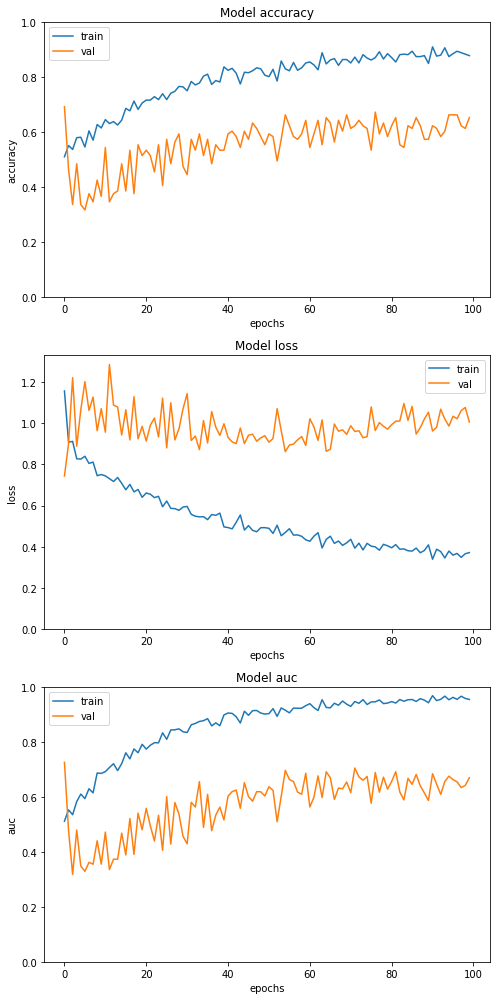

In [5]:
dat = pd.read_csv('results.csv', index_col='epoch')

fig, ax = plt.subplots(3, 1, figsize=(7,14))
metrics = ['accuracy', 'loss', 'auc']

for i, metric in enumerate(metrics):
    ax[i].plot(dat[metric])
    ax[i].plot(dat['val_'+metric])
    ax[i].set_title("Model {}".format(metric))
    ax[i].set_xlabel("epochs")
    ax[i].set_ylabel(metric)
    ax[i].legend(["train", "val"])
    
    if metric == 'accuracy' or metric == 'auc':
        ax[i].set_ylim(0,1)
        
    else:
        ax[i].set_ylim(0)
    
fig.tight_layout()
plt.show()


#### Prediction on test data

In [6]:
best_model = np.where(dat.val_loss == np.min(dat.val_loss[10:]))[0][0] 
print(best_model)

54


In [35]:
best_model = np.where(dat.val_loss == np.min(dat.val_loss[10:]))[0][0] 
print(best_model)
#best_model = np.where(dat.val_accuracy == np.max(dat.val_accuracy))[0][0]
model.load_weights('History1/model.epoch11.hdf5')

y_prob = model.predict(X_test, batch_size=batch_size)
y_pred = (y_prob[:,1] > 0.5).astype(np.int)

y_test = Y_test.argmax(axis = 1) 

IndexError: tuple index out of range

In [82]:
auc, auc_var, ci_auc = auc_ci_Delong(
    y_true=y_test,
    y_scores=y_prob[:,1])

cm = confusion_matrix(y_test, y_pred)
lower_acc, upper_acc = proportion_confint(sum(np.diag(cm)), np.sum(cm), 0.05, method = 'wilson')
ci_acc = np.array([lower_acc, upper_acc])

print("Accuracy: ", round((np.mean(y_pred == y_test)*100),2), ' CI:', np.round(ci_acc,3) )
print("AUC: ", round(auc, 3), 'CI:', np.round(ci_auc, 3))
print("Confusion matrix: \n", 
      confusion_matrix(y_test, y_pred))
print("Normalized Confusion matrix: \n", 
      np.round(confusion_matrix(y_test, y_pred, normalize = 'true'),3))

Accuracy:  65.35  CI: [0.557 0.739]
AUC:  0.684 CI: [0.573 0.795]
Confusion matrix: 
 [[18 13]
 [22 48]]
Normalized Confusion matrix: 
 [[0.581 0.419]
 [0.314 0.686]]


#### Prediction on training data

In [83]:
best_model = np.where(dat.val_loss == np.min(dat.val_loss))[0][0] 
print(best_model)
#best_model = np.where(dat.val_auc == np.max(dat.val_auc))[0][0]
#best_model = np.where(dat.val_accuracy == np.max(dat.val_accuracy))[0][0]
model.load_weights('History/model.epoch120.hdf5')

y_prob = model.predict(X_train, batch_size=batch_size)
y_pred = (y_prob[:,1] > 0.5).astype(np.int)

y_train = Y_train.argmax(axis = 1) 

53


In [84]:
cm = confusion_matrix(y_train, y_pred)
lower_acc, upper_acc = proportion_confint(sum(np.diag(cm)), np.sum(cm), 0.05, method = 'wilson')
ci_acc = np.array([lower_acc, upper_acc])

auc, auc_var, ci_auc = auc_ci_Delong(
    y_true=y_train,
    y_scores=y_prob[:,1])

print("Accuracy: ", round((np.mean(y_pred == y_train)*100),2), ' CI:', np.round(ci_acc,3) )
print("AUC: ", round(auc, 3), 'CI:', np.round(ci_auc, 3))
print("Confusion matrix: \n", 
      confusion_matrix(y_train, y_pred))
print("Normalized Confusion matrix: \n", 
      np.round(confusion_matrix(y_train, y_pred, normalize = 'true'),3))

Accuracy:  99.51  CI: [0.982 0.999]
AUC:  1.0 CI: [nan nan]
Confusion matrix: 
 [[126   0]
 [  2 279]]
Normalized Confusion matrix: 
 [[1.    0.   ]
 [0.007 0.993]]


/usr/local/lib/python3.6/dist-packages/scipy/stats/_distn_infrastructure.py:2023: RuntimeWarning: invalid value encountered in multiply
  lower_bound = _a * scale + loc
/usr/local/lib/python3.6/dist-packages/scipy/stats/_distn_infrastructure.py:2024: RuntimeWarning: invalid value encountered in multiply
  upper_bound = _b * scale + loc


#### Prediction on balanced test data

In [85]:
bool_test_labels = Y_test[:,1] != 0
pos_features_test = X_test[bool_test_labels]
neg_features_test = X_test[~bool_test_labels]
pos_labels_test = Y_test[bool_test_labels]
neg_labels_test = Y_test[~bool_test_labels]

ids = np.arange(len(neg_features_test))
choices = np.random.choice(ids, len(pos_features_test))
res_neg_features = neg_features_test[choices]
res_neg_labels = neg_labels_test[choices]

resampled_features = np.concatenate([res_neg_features, pos_features_test], axis=0)
resampled_labels = np.concatenate([res_neg_labels, pos_labels_test], axis=0)

order = np.arange(len(resampled_labels))
np.random.shuffle(order)
X_test_balanced = resampled_features[order]
Y_test_balanced  = resampled_labels[order]

In [86]:
best_model = np.where(dat.val_loss == np.min(dat.val_loss))[0][0] 
print(best_model)
#best_model = np.where(dat.val_auc == np.max(dat.val_auc))[0][0]
#best_model = np.where(dat.val_accuracy == np.max(dat.val_accuracy))[0][0]
model.load_weights('History/model.epoch120.hdf5')

y_prob = model.predict(X_test_balanced, batch_size=batch_size)
y_pred = (y_prob[:,1] > 0.5).astype(np.int)

y_test_balanced = Y_test_balanced.argmax(axis = 1) 

53


In [87]:
cm = confusion_matrix(y_test_balanced, y_pred)
lower_acc, upper_acc = proportion_confint(sum(np.diag(cm)), np.sum(cm), 0.05, method = 'wilson')
ci_acc = np.array([lower_acc, upper_acc])

auc, auc_var, ci_auc = auc_ci_Delong(
    y_true=y_test_balanced,
    y_scores=y_prob[:,1])

print("Accuracy: ", round((np.mean(y_pred == y_test_balanced)*100),2), ' CI:', np.round(ci_acc,3) )
print("AUC: ", round(auc, 3), 'CI:', np.round(ci_auc, 3))
print("Confusion matrix: \n", 
      confusion_matrix(y_test_balanced, y_pred))
print("Normalized Confusion matrix: \n", 
      np.round(confusion_matrix(y_test_balanced, y_pred, normalize = 'true'),3))

Accuracy:  64.29  CI: [0.561 0.717]
AUC:  0.695 CI: [0.606 0.784]
Confusion matrix: 
 [[42 28]
 [22 48]]
Normalized Confusion matrix: 
 [[0.6   0.4  ]
 [0.314 0.686]]


### Deep Ensemble 

In [91]:
def ensemble(width, height, depth, batch_size, count, X_test, Y_test, pat_test):
    
    model = get_model(width=w, height=h, depth=d)
    print(model.summary())
    
    metrics = [
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.AUC(name='auc')]
    
    model.compile(loss = "categorical_crossentropy",
              optimizer = keras.optimizers.Adam(learning_rate =  0.00001),
              metrics = metrics)
    
    epochs = 120
    hist = model.fit(
    resampled_data,
    validation_data=validation_dataset,
    epochs=epochs,
    verbose=1, callbacks=callback_list, 
    steps_per_epoch = resampled_steps_per_epoch,
    class_weight = class_weight)
    
    y_prob = model.predict(X_test, batch_size=batch_size)
    y_pred = (y_prob[:,1] > 0.5).astype(np.int)
    y_test = Y_test.argmax(axis = 1) 
    
    model.save('model'+str(count)+'.h5')
    
    df = pd.DataFrame()
    df.loc[:,'y_test'] = y_test
    df.loc[:,'y_pred'] = y_pred
    df.loc[:,'y_prob'] = list(y_prob[:,1])
    df.loc[:,'pat'] = pat_test
    
    return df

In [92]:
for index in range(0,5):
    reset_keras()
    
    df = ensemble(width=w, height=h, depth=d, count = index, batch_size = 4, X_test = X_test, Y_test = Y_test, pat_test = pat_test)
    
    df.to_csv('predictions'+str(index)+'.csv', index=False)

94
Model: "3dcnn"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 128, 112, 40, 1)] 0         
_________________________________________________________________
conv3d (Conv3D)              (None, 128, 112, 40, 8)   224       
_________________________________________________________________
average_pooling3d (AveragePo (None, 64, 56, 20, 8)     0         
_________________________________________________________________
batch_normalization (BatchNo (None, 64, 56, 20, 8)     32        
_________________________________________________________________
conv3d_1 (Conv3D)            (None, 64, 56, 20, 16)    3472      
_________________________________________________________________
average_pooling3d_1 (Average (None, 32, 28, 10, 16)    0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 32, 28, 10, 16)    64 